In [88]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [85]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2023-03-30 10:44:24--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.02s   

2023-03-30 10:44:25 (4.09 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [89]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [159]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['mahender',
 'jit',
 'aashu',
 'shadab',
 'sahun',
 'harish',
 'satya',
 'gulnanj',
 'ganesi',
 'dalima']

In [160]:
len(words)

6184

In [161]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [187]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:1000]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> m
..m ---> a
.ma ---> h
mah ---> e
ahe ---> n
hen ---> d
end ---> e
nde ---> r
der ---> .
... ---> j
..j ---> i
.ji ---> t
jit ---> .
... ---> a
..a ---> a
.aa ---> s
aas ---> h
ash ---> u
shu ---> .
... ---> s
..s ---> h
.sh ---> a
sha ---> d
had ---> a
ada ---> b
dab ---> .
... ---> s
..s ---> a
.sa ---> h
sah ---> u
ahu ---> n
hun ---> .
... ---> h
..h ---> a
.ha ---> r
har ---> i
ari ---> s
ris ---> h
ish ---> .
... ---> s
..s ---> a
.sa ---> t
sat ---> y
aty ---> a
tya ---> .
... ---> g
..g ---> u
.gu ---> l
gul ---> n
uln ---> a
lna ---> n
nan ---> j
anj ---> .
... ---> g
..g ---> a
.ga ---> n
gan ---> e
ane ---> s
nes ---> i
esi ---> .
... ---> d
..d ---> a
.da ---> l
dal ---> i
ali ---> m
lim ---> a
ima ---> .
... ---> k
..k ---> o
.ko ---> s
kos ---> y
osy ---> l
syl ---> a
yla ---> y
lay ---> a
aya ---> .
... ---> p
..p ---> o
.po ---> o
poo ---> r
oor ---> a
ora ---> n
ran ---> .
... ---> m
..m ---> o
.mo ---> h
moh ---> a
oha ---> m
ham ---> m
amm ---> a
mma ---> d

In [188]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([7229, 3]), torch.int64, torch.Size([7229]), torch.int64)

In [189]:
# Embedding layer for the context

emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [190]:
emb.weight.shape

torch.Size([27, 2])

<AxesSubplot: >

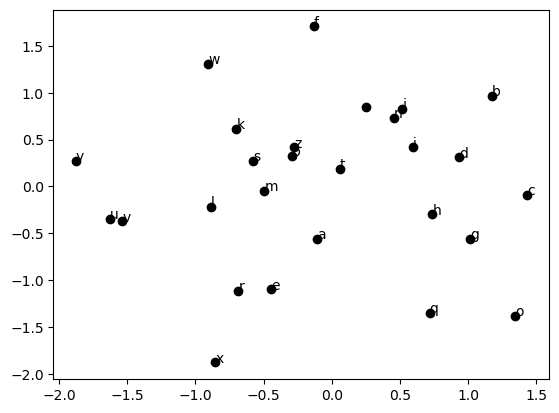

In [191]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x, y, itos[i])
    return ax

plot_emb(emb, itos)

In [192]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [201]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 50)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

qyev

veevcykfro
uewexcgdha
xbvu
xibigzhkng
flltdnioqe

avntdnaxun
ylpvygvzqf


In [202]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)

# Mini-batch training
batch_size = 4
for epoch in range(2000):
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % 100 == 0:
        print(epoch, loss.item())



0 1.1258258819580078
100 0.5126990079879761
200 0.5593062043190002


KeyboardInterrupt: 

<AxesSubplot: >

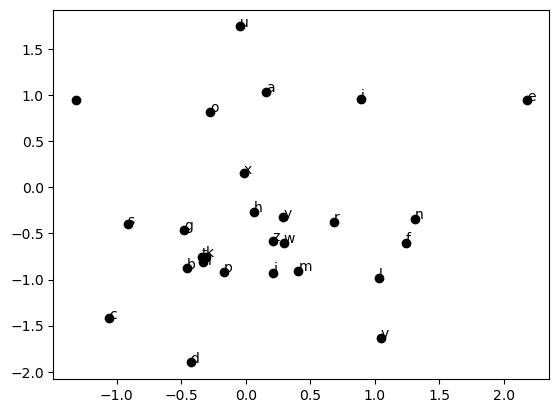

In [203]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [204]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

dev
sili
sujino
abim
ubultatin
nashtaj
naula
duna
kav
shtyi
